<a href="https://colab.research.google.com/github/mlacasa/Regression/blob/main/XGBoostRegressorHyperparamBostonData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lazypredict

In [5]:
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split

boston = datasets.load_boston() #Carga de datos
X, y = shuffle(boston.data, boston.target, random_state=13) # separar variable dependiente y =  precio medio



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12) # Observar cómo cambia R-Squared del 10% al 25% test

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 42/42 [00:02<00:00, 14.74it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.90       0.91  2.71        0.16
HistGradientBoostingRegressor                0.90       0.91  2.76        0.32
ExtraTreesRegressor                          0.90       0.91  2.80        0.21
LGBMRegressor                                0.89       0.90  2.87        0.07
XGBRegressor                                 0.88       0.90  2.95        0.08
RandomForestRegressor                        0.87       0.88  3.11        0.34
BaggingRegressor                             0.86       0.87  3.30        0.05
AdaBoostRegressor                            0.84       0.85  3.52        0.13
PoissonRegressor                             0.81       0.83  3.78        0.02
DecisionTreeRegressor                        0.80       0.82  3.92        0.02
KNeighborsRegressor                          0.78   

In [6]:
# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# HYPEROPT 

https://github.com/hyperopt/hyperopt/wiki/FMin

**The available hyperopt optimization algorithms are -**


* **hp.choice**(label, options) — Escoje una opción entre las ofrecidas.

* **hp.randint**(label, upper) — Escoje un valor al azar entre el rango.

* **hp.uniform**(label, low, high) — Retorna un valor entre el rango.

* **hp.quniform**(label, low, high, q) — Retorna un valor (uniform(low, high) / q) * q, i.e donde q es el intervalo.

* **hp.normal**(label, mean, std) — Retorna un valor R, distribuido Normal.

Mean Square Error

$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2$

In [13]:
# Cargamos librerías de hyperopt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Escogemos los parámetros a evaluar

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        #'n_estimators':180,
        'subsample': hp.uniform('subsample', 0.5,1),
        'n_estimators': hp.uniform('n_estimators', 100, 500),
        'eta': hp.uniform('eta', 0.1, 0.5)
    }
# Definimos la función que retorna el score
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), 
                           max_depth = int(space['max_depth']), 
                           gamma = space['gamma'],
                           reg_alpha = int(space['reg_alpha']),
                           min_child_weight=space['min_child_weight'],
                           colsample_bytree=space['colsample_bytree'],
                           eta = space['eta'],
                           subsample = space['subsample'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    #print ("SCORE:", mse)
    #Cambiar métrica
    return {'loss':mse, 'status': STATUS_OK, 'model': model}    # En regressión, mse.
 # Definimos el optimizador   

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=500, # Valor importante, normalmente más de 500 no mejora
            trials=trials)
# Mostramos los valores óptimos
print (best)

100%|██████████| 500/500 [00:55<00:00,  9.08it/s, best loss: 8.376680362359807]
{'colsample_bytree': 0.8946348471969481, 'eta': 0.10007069539466903, 'gamma': 4.906787617454164, 'max_depth': 8.0, 'min_child_weight': 2.0, 'n_estimators': 283.92142865730233, 'reg_alpha': 40.0, 'reg_lambda': 0.15728160069610894, 'subsample': 0.8731774473154372}


In [14]:
# Ejecutamos el modelo con los parámetros seleccionados.

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute

model = XGBRegressor(colsample_bytree=0.89,
                     eta = 0.1,
                     gamma = 4.9,
                     max_depth=8, 
                     min_child_weight=2, 
                     n_estimators = 283,
                     reg_alpha = 40.0, 
                     reg_lambda = 0.15,
                     subsample = 0.87)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1) # Se repite 3 veces, con 5 grupos train.
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1) # n_jobs = -1, utiliza todos los procesadores posibles.
# En caso que scores sea negativo.
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 2.569 (0.329)


Calculamos el R2 score mediante la función:

$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

In [15]:
# Del modelo seleccionado, queremos saber el R-2 Square, y si hay overfitting

from sklearn.metrics import r2_score
model.fit(X_train, y_train, verbose=False)
y_train_pred1 = model.predict(X_train)
y_pred1 = model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred1, y_train)) # Valor R-2 Square train y test
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1) # MSE train y test
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.9398517490535233
Test r2 score:  0.8968212445343838
Train RMSE: 2.0936
Test RMSE: 2.9410


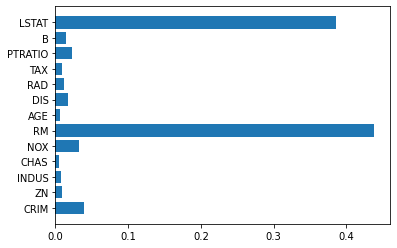

In [16]:
# Mostrar las variables más influyentes.

from matplotlib import pyplot
pyplot.barh( boston.feature_names, model.feature_importances_)
pyplot.show()